---
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ov-mGBvQzAf3sAXGe_AAxE7JQFDgGOi5?usp=sharing)

#Metrics

---

##Introduction
This notebook explores fraud detection using Logistic Regression on an imbalanced dataset. Since fraud cases are rare compared to normal ones, traditional accuracy metrics become misleading.
We address this issue by:

Building a baseline model with logistic regression

Using class weights to handle imbalance

Optimizing model using GridSearchCV with multiple scoring metrics

Exploring and visualizing the impact of precision and recall

Creating a custom scoring function that balances both metrics

The goal is to find a model that minimizes false positives and false negatives, depending on the business requirement (risk of missing fraud vs flagging normal transactions).

##Dataset Analysis

###Importing Libraries


In [3]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

###Loading the Dataset

We are loading the `creditcard.csv` file which contains credit card transaction data.

Credit Card Fraud Dataset Download [click here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

In [4]:
#Loading Dataset creditcard fraud csv available in same directory
df = pd.read_csv('creditcard.csv')[0:80_000]  # Selecting only the first 80,000 rows for faster processing

###Splitting Features and Target

Before training a machine learning model, we need to separate:

- **Features (`X`)**: The inputs used to make predictions.
- **Target (`y`)**: The output or label we want the model to learn to predict.

Also dropping Unnecessary Columns from Features



In [5]:
#Feature and Target splitting
#Removing unnecessary columns
X = df.drop(columns=['Time', 'Amount', 'Class']).values  #Dropping Time and amount do not makes sense while training and Class is target

#Extracting the target variable ('Class')
y = df['Class'].values #1 = fraud , 0 clean

### Displaying data

Before training a model, it’s important to understand the **distribution of the data**, especially in fraud detection where data is highly imbalanced.




In [6]:
fraud_cases = y.sum()  # Count total fraud cases in dataset

print(f"X Shape (feature): {X.shape} | y Shape (target) : {y.shape}")
print(f"Fraud Cases: {fraud_cases} out of {len(y)} transactions ({(fraud_cases / len(y)) * 100:.4f}%)")

#This is total fraud cases what we saw here meaning 196 in 80000 are 1 ,
# we didnt predict yet its just we splitted the dattaset in feature and targets and see the data set

X Shape (feature): (80000, 28) | y Shape (target) : (80000,)
Fraud Cases: 196 out of 80000 transactions (0.2450%)


## Logistic Regression

We are now setting up a machine learning model to detect fraud.

## Importing Logistic Regression

Logistic Regression is a binary classification algorithm — ideal when the output is either fraud (1) or not fraud (0).

It works by estimating the probability that a given input belongs to a certain class (in this case, fraud).

This model will be used to train on our feature data (X) and learn to predict the target (y).


In [7]:
#Fraud Detection using Logistic regression
from sklearn.linear_model import LogisticRegression

### Class Weights

In fraud detection, the dataset is usually **imbalanced** — there are many more non-fraud cases than fraud cases. If we train a model without addressing this, it might **ignore the minority class (fraud)**.

To handle this, we give **more importance (weight)** to the fraud class during training.

- class_weight={0: 1, 1: 2}:
Assigns double weight to the fraud class (1) compared to the non-fraud class (0).

   This means the model will penalize misclassifying fraud more than misclassifying clean transactions.

- max_iter=1000:
Increases the maximum number of iterations to ensure the model has enough time to converge.


In [8]:
# Logistic Regression Model with Class Weights
# Giving higher weight to minority class (fraud cases) to handle imbalance
model = LogisticRegression(class_weight={0:1,1:2}, max_iter=1000) #1(fraud)value =2  ;class_weight=dictionary

###Training

Now that the model is defined, we train it using our feature data (`X`) and target labels (`y`).

- .fit(X, y) tells the model to learn the relationship between the features and the target.

- The model will use the logistic regression algorithm to find the best parameters that separate fraud (1) from non-fraud (0) cases.


In [9]:
#Model Training
model.fit(X, y)

LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000)

###Prediction

Now that the model is trained, we use it to make predictions on the same dataset (`X`).

- Predicts the class label (fraud or not fraud) for each transaction.

- The result is stored in the prediction array, which contains either 0 (not fraud) or 1 (fraud) for every row in X.

In [10]:
#Prediction
prediction= model.predict(X)

###Accuracy

To evaluate the model’s performance, we calculate the accuracy — how often the model's predictions match the actual labels.



In [11]:
#Accuracy
accuracy=(prediction==y).mean()
print(accuracy )

0.998825


`⚠️ Keep in mind: Accuracy can be misleading in imbalanced datasets like this one (where fraud cases are rare). A model predicting all 0s would still have high accuracy.`

####This checks how many transactions the model has predicted as fraud.

In [12]:

print(f'Fraud Precdiction from LogisticRegression: {prediction.sum()}\nout of Total Prediction {fraud_cases}')


Fraud Precdiction from LogisticRegression: 172
out of Total Prediction 196


##GridSearchCV

Until now, we trained a basic Logistic Regression model and evaluated it using accuracy and predicted fraud count.

Now, we move to the **main concept** of this notebook: using **GridSearchCV** to systematically tune and evaluate the model’s performance.

###What is GridSearchCV?

`GridSearchCV` helps us:
- **Search for the best combination of hyperparameters** (like class weights).
- **Automatically evaluate performance** using cross-validation.
- **Optimize based on custom metrics**, such as precision or recall


In [13]:
#GridSearchCV
from sklearn.model_selection import GridSearchCV

###GridSearchCV for Tuning `class_weight` in Logistic Regression

To improve fraud detection, we now use **GridSearchCV** to find the best `class_weight` for Logistic Regression.

Breakdown:

- estimator=model:
Uses our previously defined LogisticRegression(max_iter=1000) model.

- param_grid={'class_weight': [{0: 1, 1: v} for v in range(1, 5)]}:
Tries different weights (1, 2, 3, 4) for the fraud class (1) while keeping class 0 at weight 1.
This helps the model give more attention to minority class depending on which weight performs best.

- cv=10:
Performs 10-fold cross-validation to prevent overfitting and ensure reliable performance evaluation.

- n_jobs=-1:
Uses all CPU cores to speed up the grid search.

In [14]:
# GridSearchCV for tuning class_weight of Logistic Regression
grid = GridSearchCV(
    estimator=model,  #=LogisticRegression(max_iter=1000)
    param_grid={'class_weight': [{0: 1, 1: v} for v in range(1, 5)]},  # Trying different weights for class 1 (fraud) ;class weight in gridSearch = Array
    cv=10,                # 4-fold cross-validation which is remedy for overfitting
    n_jobs=-1            # Use all CPU cores
)



###Training
#### Training the Model with GridSearchCV

Now we run the grid search to train and evaluate the model across different class weight settings.

.fit(X, y) triggers GridSearchCV to:

- Train the model for each class weight in the parameter grid.

- Use 10-fold cross-validation to evaluate performance.
 - ***Cross-validation ***(like cv=10) splits the data into multiple train-test sets.

    The model is trained on different parts of the data and evaluated on unseen parts.

    This gives a more honest estimate of model performance than just training and testing on the same data.

In [15]:
#Grid Train
model_grid=grid.fit(X,y)

###Prediction
####Making Predictions with the Best GridSearchCV Model

After training with GridSearchCV, we now use the **best-found model** to make predictions.




In [16]:
#Predict grid
prediction_grid=model_grid.predict(X)


###Accuracy
####Evaluating the Tuned Model with Accuracy (⚠️ Not Always Useful Here)












In [17]:
accuracy_grid=(prediction_grid==y).mean()
print(f'Accuracy Grid: {accuracy_grid}')
print(f'Fraud Precdiction from LogisticRegression: {prediction.sum()}\nFraud Prediction from GridSearchCV: {prediction_grid.sum()}\nout of Total Prediction {fraud_cases}')


Accuracy Grid: 0.9990375
Fraud Precdiction from LogisticRegression: 172
Fraud Prediction from GridSearchCV: 189
out of Total Prediction 196


```
⚠️ Important Note on Accuracy:
While accuracy might look good, it's misleading in highly imbalanced datasets like fraud detection.

In our dataset, fraud cases are extremely rare (e.g., ~0.25%).

A model could predict everything as "not fraud" (0) and still achieve >99% accuracy — but miss all frauds, which defeats the purpose.

That’s why we don’t rely on accuracy alone.

Better metrics for imbalanced problems include:

Precision

Recall

F1 Score

Confusion Matrix
```

###Display Results

In [18]:
# Display cross-validation results

print(pd.DataFrame(grid.cv_results_)) #Pandas


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.339709      0.051631         0.002162        0.000250   
1       0.656585      0.311540         0.003756        0.003855   
2       0.456646      0.069742         0.003251        0.002942   
3       0.317902      0.032713         0.002561        0.001003   

  param_class_weight                          params  split0_test_score  \
0       {0: 1, 1: 1}  {'class_weight': {0: 1, 1: 1}}           0.998500   
1       {0: 1, 1: 2}  {'class_weight': {0: 1, 1: 2}}           0.998625   
2       {0: 1, 1: 3}  {'class_weight': {0: 1, 1: 3}}           0.999125   
3       {0: 1, 1: 4}  {'class_weight': {0: 1, 1: 4}}           0.999625   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.997250           0.998125           0.998750           0.998375   
1           0.997000           0.998125           0.999625           0.998375   
2           0.996875           0.998125      

##Tuning

What's Going On Here?
param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 10)]}
→ This tries 10 different class weights for class 1 (fraud), ranging linearly from 1 to 20.

make_scorer(precision_score)
→ Wraps the precision metric into a format that GridSearchCV can use.
→ Precision tells us: Out of all predicted frauds, how many were actually fraud?

make_scorer(recall_score)
→ Measures how well the model catches actual frauds.
→ Recall tells us: Out of all actual frauds, how many did the model catch?

refit='precision'
→ Tells GridSearchCV to pick the model that gave the best precision score after trying all class weights.



In [19]:
#Tuning GridSearchCV with Precion and recall Score
from sklearn.metrics import make_scorer,precision_score,recall_score

# Setup GridSearchCV to find optimal class_weight for class 1 (fraud)
model_grid = GridSearchCV(
    estimator= model,
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 10)]},  # Trying weights from 1 to 20 (10 steps)
    scoring={ 'precision': make_scorer(precision_score),
              'recall_score': make_scorer(recall_score)
            },
    refit='precision',           # Optimize for precision ; can be recall too
    return_train_score=True,     # Track training score
    cv=10,                       # 10-fold cross-validation
    n_jobs=-1                    # Use all cores
)


###Training

In [20]:
# Train the model
model_grid.fit(X, y)


GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight={0: 1, 1: 2},
                                          max_iter=1000),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: np.float64(1.0)},
                                          {0: 1,
                                           1: np.float64(3.111111111111111)},
                                          {0: 1,
                                           1: np.float64(5.222222222222222)},
                                          {0: 1,
                                           1: np.float64(7.333333333333334)},
                                          {0: 1,
                                           1: np.float64(9.444444444444445)},
                                          {0: 1,
                                           1: np.float64(11.555555555555555)},
                                          {0: 1,
                                           1: np.float64(13.666666666666668)},
                                          {0: 1,
                                           1: np.float64(15.777777777777779)},
                                          {0: 1,
                                           1: np.float64(17.88888888888889)},
                                          {0: 1, 1: np.float64(20.0)}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score, response_method='predict'),
                      'recall_score': make_scorer(recall_score, response_method='predict')})

###Matplotlib
After training with `GridSearchCV`, we extract the cross-validation results and plot how **precision** and **recall** change with different class weights.

#### Why this matters:
- **Precision** helps minimize false positives (flagging legit transactions as fraud).
- **Recall** helps minimize false negatives (missing actual frauds).
- The goal is to **balance** both  depending on business priorities.
- This plot helps **visualize trade-offs** between the two metrics as we adjust the importance (weight) of the fraud class.

We’ll now plot these metrics to understand how class weight influences performance.


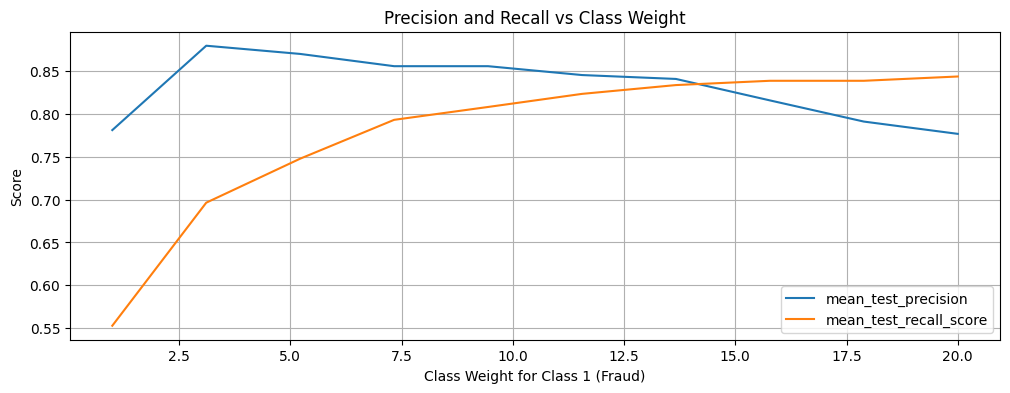

In [21]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(model_grid.cv_results_)

# Plotting the scores for each class weight tried
for score in ['mean_test_precision', 'mean_test_recall_score']:
    plt.plot(
        [cw[1] for cw in df_results['param_class_weight']],
        df_results[score],
        label=score
    )

plt.title('Precision and Recall vs Class Weight')
plt.xlabel('Class Weight for Class 1 (Fraud)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()



##Custom Scoring Function
###Minimum of Precision and Recall

In imbalanced classification problems like fraud detection, optimizing only precision or recall can be misleading.

To ensure neither metric is disproportionately low, we define a **custom scoring function** that returns the **minimum** of precision and recall.

### Why use `min(recall, precision)`?

Precision ensures we don’t wrongly accuse innocent users (low false positives).

Recall ensures we catch most frauds (low false negatives).

Optimizing only one metric can cause the other to collapse:

High precision → might miss real frauds (low recall).

High recall → might flag many legit transactions (low precision).

That's where our custom scoring feature of GridSearchCV Comes making it possible to make custon fuction like min(precision, recall)

Forces the model to balance both metrics.

Acts as a guardrail against extreme bias toward just one.

Ensures neither metric drops too low, which is critical in real-world deployment.

Use when you want balanced performance and no weak points.

In [22]:
# Returns the lower of precision and recall for a prediction
# This helps ensure neither metric is disproportionately low

def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)


###GridSearch with custom function

In [23]:
from sklearn.metrics import make_scorer,precision_score,recall_score

# GridSearchCV Setup
# - Refit the model using the custom score

model_grid = GridSearchCV(
    estimator=model,#Logistic Egression (iter=1000)
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 10)]},
    scoring={
        'precision': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'min_both': make_scorer(min_recall_precision) #Custom Mae fuction which gives both precision and recall
    },
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)

###Training

In [24]:
# Run the grid search
model_grid.fit(X, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight={0: 1, 1: 2},
                                          max_iter=1000),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: np.float64(1.0)},
                                          {0: 1,
                                           1: np.float64(3.111111111111111)},
                                          {0: 1,
                                           1: np.float64(5.222222222222222)},
                                          {0: 1,
                                           1: np.float64(7.333333333333334)},
                                          {0: 1,
                                           1: np.float64(9.444444444444445)},
                                          {0: 1,
                                           1: np.float64(11.555555555555555)},
                                          {0: 1,
                                           1: np.f...
                                           1: np.float64(15.777777777777779)},
                                          {0: 1,
                                           1: np.float64(17.88888888888889)},
                                          {0: 1, 1: np.float64(20.0)}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': make_scorer(min_recall_precision, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall_score': make_scorer(recall_score, response_method='predict')})

###Matplotlib

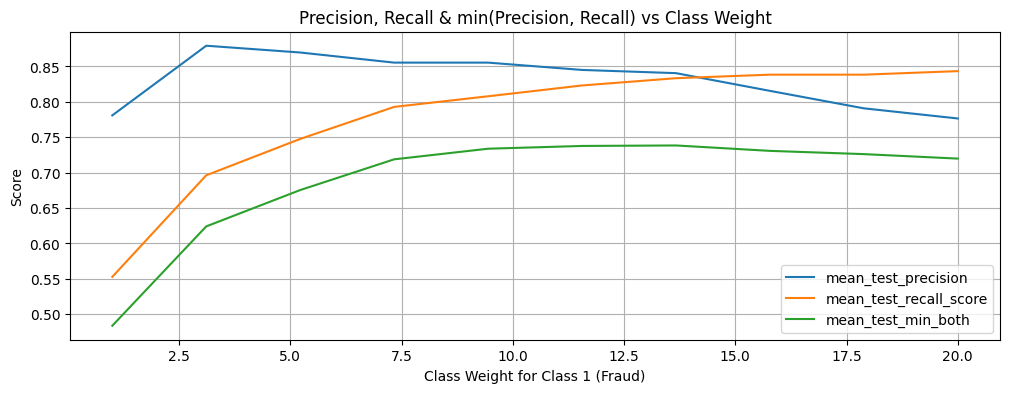

In [25]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(model_grid.cv_results_)

for score in ['mean_test_precision', 'mean_test_recall_score', 'mean_test_min_both']:
    plt.plot(
        [cw[1] for cw in df_results['param_class_weight']],
        df_results[score],
        label=score
    )
plt.title('Precision, Recall & min(Precision, Recall) vs Class Weight')
plt.xlabel('Class Weight for Class 1 (Fraud)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()



## Summary
Baseline Model was trained using LogisticRegression(max_iter=1000) and evaluated on raw accuracy.

Observed that accuracy is misleading for imbalanced datasets; even poor fraud detection gives high accuracy.

Used GridSearchCV to tune class_weight and improve fraud detection via precision and recall.

Visualized how both metrics vary with weight adjustments.

Introduced a custom scoring function (min(precision, recall)) to ensure neither metric is disproportionately low.

Final model is selected using refit='min_both' which prioritizes a balance between precision and recall.

This structured tuning pipeline helps avoid overfitting and allows us to make data-driven decisions on trade-offs between catching frauds and minimizing false alarms.

---
##  Navigation

[![➡️ Next](https://img.shields.io/badge/Next-postprocessing-000000?style=for-the-badge&logo=github&logoColor=00FF80)](https://github.com/aypy01/scikit-learn/tree/main/post-processing)
&nbsp;&nbsp;&nbsp;&nbsp;

---

---
## Author
 <p align="left">
  Created and maintained by
  <a href="https://github.com/aypy01" target="_blank">&nbsp Aaditya Yadav</a>&nbsp
  <a href="https://github.com/aypy01" target="_blank">
    <img src="https://img.shields.io/badge/aypy01-000000?style=flat-square&logo=github&logoColor=00FF80" alt="GitHub Badge"/>
  </a>
</p>

</p>
<p align="left">
  <img src="https://readme-typing-svg.demolab.com?font=Fira+Code&duration=3000&pause=500&color=00FF80&center=false&vCenter=false&width=440&lines=Break+Things+First%2C+Understand+Later;Built+to+Debug%2C+Not+Repeat;Learning+What+Actually+Sticks;Code.+Observe.+Refine." alt="Typing SVG" />
</p>

---



---

## License

This project is licensed under the [![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT).

---